In [19]:
%load_ext autoreload
%autoreload 2

import itertools

import torch
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from allennlp.data.token_indexers.wordpiece_indexer import PretrainedBertIndexer

from awesome_sst.task import Task
from awesome_sst.config import Config

from luna import ram_write, chunks
from allennlpx import allenutil
from openTSNE import TSNE as OTSNE
from openTSNE.callbacks import ErrorLogger

from adjustText import adjust_text


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
class Config:
    def __init__(self):
        super().__init__()
        self.pretrain = "fasttext_ol"
        self.fix_embed = True
        # self.mode = 'train'

        self.bert_noise = 0.0
        self.embed_noise = 0.0
        self.lstm_noise = 0.0

config = Config()        
ram_write("config", config)

task = Task(config) # type: Task
task.from_trained()


cache for fasttext_ol_data exists


 25%|██▌       | 25384/101487 [00:00<00:00, 126408.95it/s]

*** load fasttext_ol_data from cache cost 2.87 seconds
cache for fasttext_ol_vocab does not exist


100%|██████████| 101487/101487 [00:00<00:00, 123233.74it/s]


*** create fasttext_ol_vocab and save to cache cost 0.869 seconds
cache for 19e48dadf57a9ee4c7f9dcfccc19085d exists
*** load 19e48dadf57a9ee4c7f9dcfccc19085d from cache cost 0.00722 seconds
LstmClassifier(
  (word_embedders): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (encoder): PytorchSeq2VecWrapper(
    (_module): LSTM(300, 512, num_layers=2, batch_first=True)
  )
  (linear): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): CrossEntropyLoss()
)
Restore model from checkpoint saved/models/fasttext_ol_model_feat@0.ckpt.


In [21]:
# next(zip(*list(task.model.named_parameters())))

In [39]:
idx_1 = task.vocab.get_token_index('1', 'labels')
idx_0 = task.vocab.get_token_index('0', 'labels')


if config.pretrain == 'bert':
#     tgt_module = "word_embedders.token_embedder_tokens.bert_model.pooler.activation"
    tgt_module = "word_embedders.token_embedder_tokens.bert_model.encoder.layer.11"
else:
    tgt_module = "encoder"

with torch.no_grad():
    sst_embeds = []
    sst_preds = []
    sst_labels = []
    for instances in chunks(task.test_data, 300):
        with task.predictor.capture_named_internals(tgt_module) as internals:
            outputs = task.predictor.predict_batch_instance(instances)
            if config.pretrain == 'bert':
                sst_embeds.append(internals[tgt_module][:, 0]) # GET [CLS]
            else:
                sst_embeds.append(internals[tgt_module])
        
        for i, ele in enumerate(outputs):
            sst_preds.append(ele['probs'][idx_1] > ele['probs'][idx_0])
        for instance in instances:
            sst_labels.append(instance.fields['label'].label == '1')
    sst_embeds = torch.cat(sst_embeds, dim=0)
torch.cuda.empty_cache()
# sst_embeds.size()
# otsne = OTSNE(initialization='pca', negative_gradient_method='bh')
# sst2ds = otsne.fit(sst_embeds.cpu().numpy())
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.scatter(sst2ds[:, 0][np.array(sst_labels)], sst2ds[:, 1][np.array(sst_labels)], c='#00FF0020', label='pos', marker='+')
# plt.scatter(sst2ds[:, 0][~np.array(sst_labels)], sst2ds[:, 1][~np.array(sst_labels)], c='#FF000020', label='neg', marker='+')

torch.Size([1821, 512])

In [43]:
@torch.no_grad()
def get_internals(sent='hello world', inc=False):
    sent = sent.split(" ")
    inc_sents = []
    if inc:
        for ti in range(1, len(sent) + 1):
            inc_sents.append({"sentence": allenutil.as_sentence(sent[:ti])})
    else:
        inc_sents.append({"sentence": allenutil.as_sentence(sent)})
    sent_embeds = []
    sent_preds = []
    with task.predictor.capture_named_internals(tgt_module) as internals:
        outputs = task.predictor.predict_batch_json(inc_sents)
        if config.pretrain=='bert':
            sent_embeds.append(internals[tgt_module][:, 0]) # GET [CLS]
        else:
            sent_embeds.append(internals[tgt_module])
    for i, ele in enumerate(outputs):
        sent_preds.append(ele['probs'][idx_1] > ele['probs'][idx_0])
    sent_embeds = torch.cat(sent_embeds, dim=0)
    return sent_embeds, sent_preds

In [44]:
class TSNEPlotter:
    def __init__(self, embeds: np.ndarray, mask, base_num: int, annotations):
        self.embeds = embeds
        self.mask = mask
        self.base_num = base_num
        otsne = OTSNE(initialization='pca', negative_gradient_method='bh')
        self.points = otsne.fit(self.embeds)
        self.annotations = annotations
        
    def plot(self):
        plt.rcParams['figure.figsize'] = [10, 10]
        bases = self.points[:self.base_num]
        pos_mask = np.array(self.mask[:self.base_num])
        plt.scatter(bases[:, 0][pos_mask], bases[:, 1][pos_mask], c='#00FF0020', label='pos', marker='+')
        plt.scatter(bases[:, 0][~pos_mask], bases[:, 1][~pos_mask], c='#FF000020', label='neg', marker='+')   
        
        news = self.points[self.base_num:]
        pos_mask = self.mask[self.base_num:]
        texts = []
        for idx in range(news.shape[0]):
            plt.scatter(news[idx, 0], news[idx, 1], c='g' if pos_mask[idx] else 'r', marker='x', s=10)
            texts.append(plt.text(news[idx, 0], news[idx, 1], 
                                  self.annotations[idx], 
                                  ha='center', va='center'))
        adjust_text(texts)
        plt.legend()
    

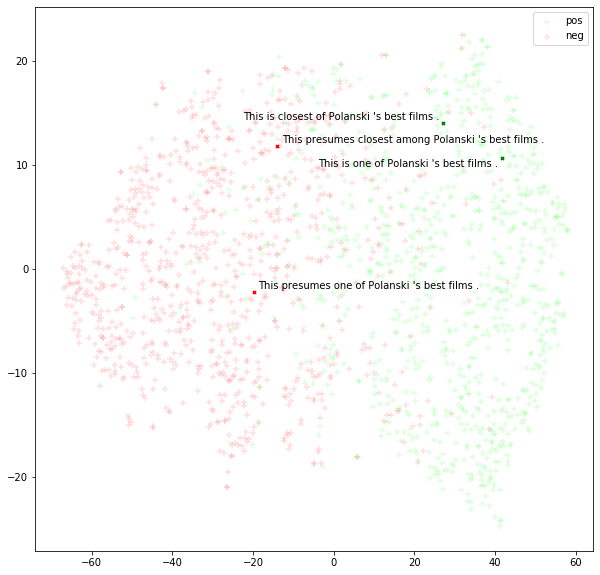

In [51]:
# allenutil.as_sentence(instance)
mysents = [
#     "Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .",
#     "Emerges too much rare , an issue movie that 's only honest and keenly observed that here does n't feel like one .",
#     "Offers that rare combination of entertainment and education .",
#     "Offers why rare combination of entertainment and education .",
    
#     "Offers why seldom combined of entertainment and education .",
#     "Offers why rare combined of entertainment and education .",
    
    "This is one of Polanski 's best films .",
    "This presumes one of Polanski 's best films .",
    "This is closest of Polanski 's best films .",
    "This presumes closest among Polanski 's best films ."
    
#     "Daring , mesmerizing and exceedingly hard to forget .",
#     "Daring , mesmerizing then exceedingly hard way forgot .",
    
#     "Daring , mesmerizing and exceedingly hard to forget .",
#     "Daring , mesmerizing and exceedingly hard to forgot .",
#     "Daring , mesmerizing and exceedingly hard way forget .",
#     "Daring , mesmerizing and exceedingly hard way forgot .",
    
#     "An unabashedly schmaltzy and thoroughly enjoyable true story .",
#     "An unabashedly triteness the minutely enjoyable contrary story .",
    
#     "A thoughtful look at a painful incident that made headlines in 1995 .",
#     "A thoughtful stare the just painful incident itself made headlines in 1995 ."

#     "I like you .",
#     "I do not like you .",
#     "I hate you .",
#     "I do not hate you .",    
]
my_embeds = []
my_preds = []
for sent in mysents:
    embed, pred = get_internals(sent)
    my_embeds.append(embed)
    my_preds.extend(pred)
my_embeds = torch.cat(my_embeds, dim=0)

all_embeds = np.concatenate([sst_embeds.cpu().numpy(), my_embeds.cpu().numpy()])

plotter = TSNEPlotter(all_embeds, 
                      mask = sst_labels + my_preds,
                      base_num =sst_embeds.shape[0], 
                      annotations=mysents
#                       annotations=[str(idx) for idx in range(len(mysents))]
                     )
plotter.plot()


In [29]:
sst_preds

[True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 T

In [86]:
# allenutil.as_sentence(instance)
mysents = [
    "The dog is lovely , it is not scary .",
    "The dog is not lovely , it is scary.",
    "The dog is scary , it is not lovely .",
    "The dog is not scary , it is lovely .",
#     "I like you .",
#     "I do not like you .",
#     "I hate you .",
#     "I do not hate you .",    
]
myembeds = []
mypreds = []
for sent in mysents:
    pp = ""
    for i, ele in enumerate(sent.split(" ")):
        pp += f"{ele}'{i} "
    print(pp)
    embed, pred = get_internals(sent, False)
    myembeds.append(embed)
    mypreds.append(pred)
myembeds = torch.cat(myembeds, dim=0)
 

The'0 dog'1 is'2 lovely'3 ,'4 it'5 is'6 not'7 scary'8 .'9 
The'0 dog'1 is'2 not'3 lovely'4 ,'5 it'6 is'7 scary.'8 
The'0 dog'1 is'2 scary'3 ,'4 it'5 is'6 not'7 lovely'8 .'9 
The'0 dog'1 is'2 not'3 scary'4 ,'5 it'6 is'7 lovely'8 .'9 


In [85]:
   
allembeds = np.concatenate([sstembeds, myembeds])
otsne = OTSNE(initialization='pca', negative_gradient_method='bh')
otsne.fit()

    
mask = sent_preds
plt.rcParams['figure.figsize'] = [10, 10]
for mynum in range(1, len(mysents) + 1):
    plt.subplot(2, 2, mynum)

    cur_sent = mysents[mynum - 1]
    cur_words = cur_sent.split(" ")
    cur_pred = mypreds[mynum - 1]
    
    plt.scatter(sent2ds[:, 0][np.array(sst_labels)], sent2ds[:, 1][np.array(sst_labels)], c='#00FF0020', label='pos', marker='+')
    plt.scatter(sent2ds[:, 0][~np.array(sst_labels)], sent2ds[:, 1][~np.array(sst_labels)], c='#FF000020', label='neg', marker='+')   
    
    start_idx = sum(allsizes[:mynum])
    end_idx = sum(allsizes[:mynum+1])
    fooembed = all2ds[start_idx: end_idx]
    plt.scatter(fooembed[:, 0], fooembed[:, 1], c='b', marker='x', s=10)
    texts = [plt.text(fooembed[i, 0], fooembed[i, 1], "{}-{}-{}".format(i, cur_words[i], "p" if cur_pred[i] else 'n'), ha='center', va='center') for i in range(fooembed.shape[0])]
    adjust_text(texts)
    
    plt.legend()

The'0 dog'1 is'2 lovely'3 ,'4 it'5 is'6 not'7 scary'8 .'9 
The'0 dog'1 is'2 not'3 lovely'4 ,'5 it'6 is'7 scary.'8 
The'0 dog'1 is'2 scary'3 ,'4 it'5 is'6 not'7 lovely'8 .'9 
The'0 dog'1 is'2 not'3 scary'4 ,'5 it'6 is'7 lovely'8 .'9 


AttributeError: 'TSNE' object has no attribute 'prepare_partial'

In [83]:
myembeds[0].size()

torch.Size([10, 768])